In [350]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [351]:
Df = pd.read_csv('Faellesdata_cleaned.csv')

In [352]:
x_train, x_test, y_train, y_test = train_test_split(Df.drop('IsMigratorInt', axis=1), Df['IsMigratorInt'], test_size=0.2, random_state=42)

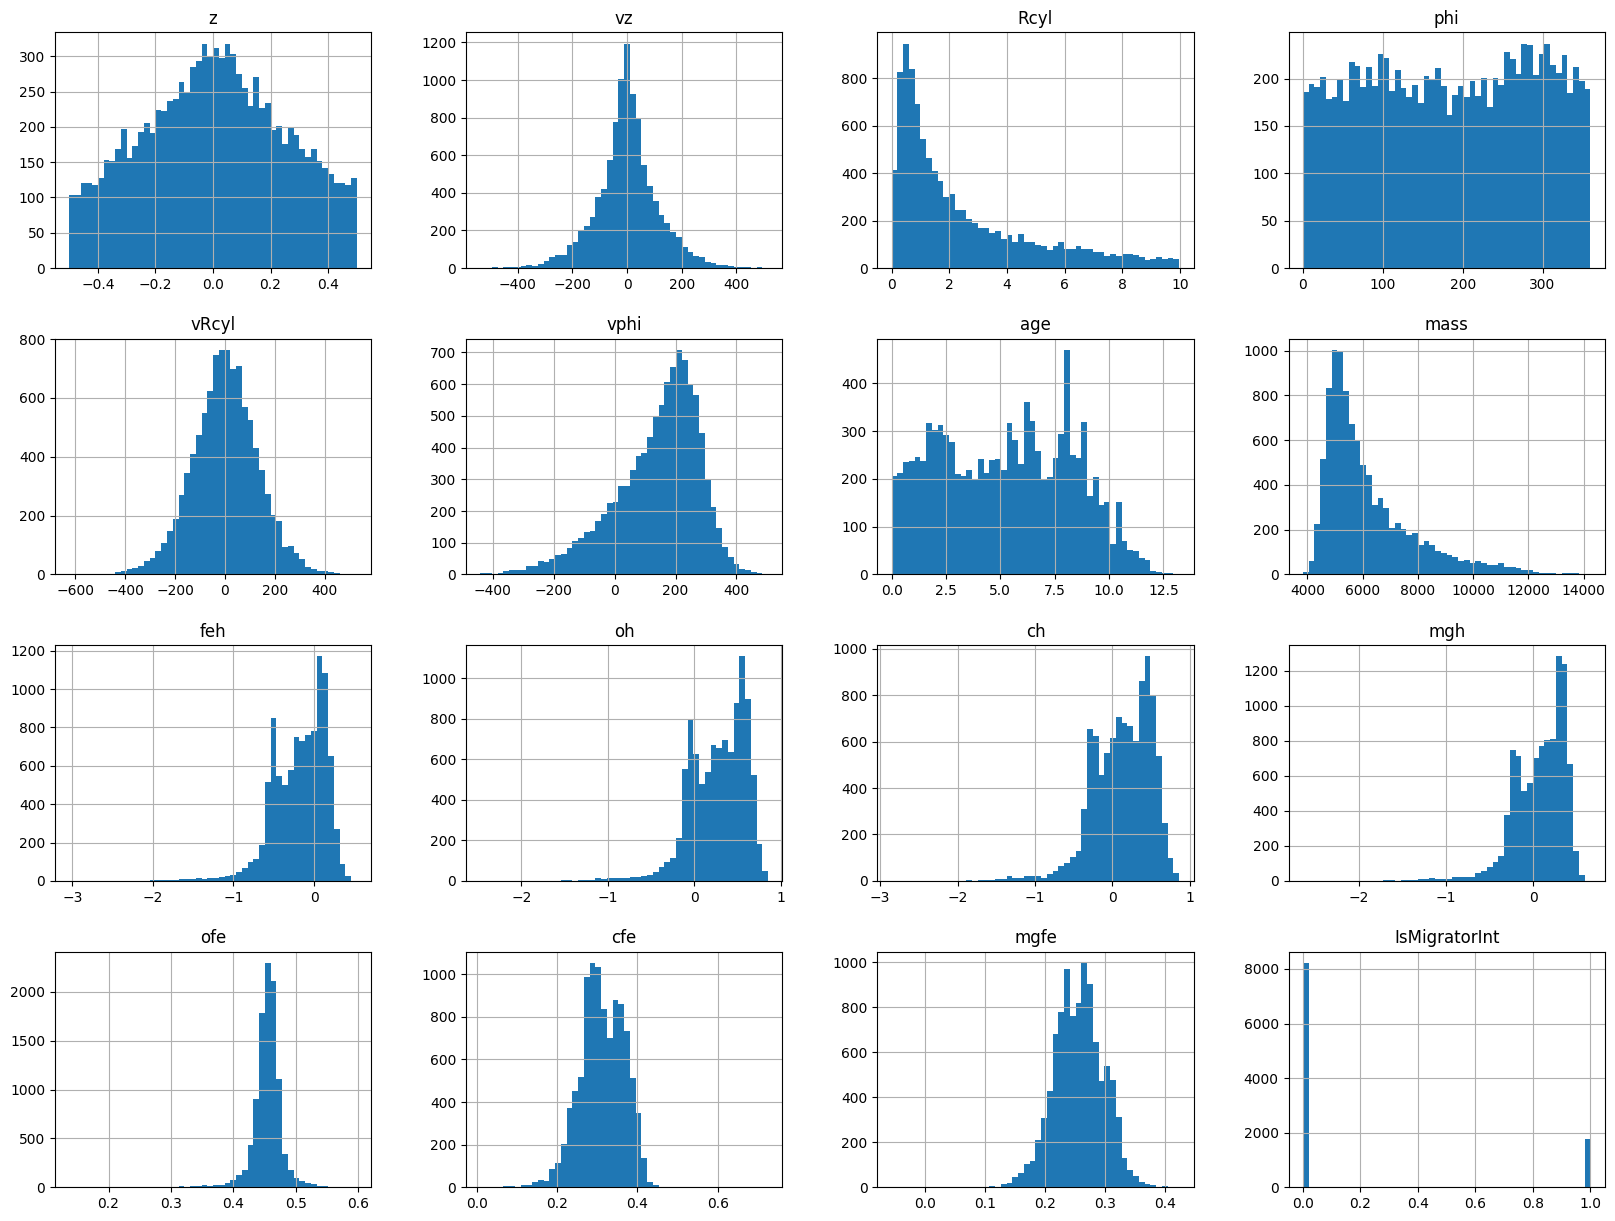

In [353]:
Df.hist(bins = 50, figsize = (20, 15));
#plt.savefig("Histograms")

In [354]:
import statsmodels.api as sm
import time
import itertools
from ISLP.models import (ModelSpec as MS,
                         summarize, poly)

In [355]:
#Make dataframe thats called DataFinal that has x_train and y_train
DataFinal = x_train
DataFinal['IsMigratorInt'] = y_train


In [356]:
DataFinalTest = x_test
DataFinalTest['IsMigratorInt'] = y_test

In [357]:
# Found on google
def processSubset(feature_set):
    # Fit model on feature_set and calculate Cross entropy
    X = MS(list(feature_set)).fit_transform(DataFinal[list(feature_set)])
    model = sm.GLM(
        DataFinal["IsMigratorInt"]
        , X
        , family = sm.families.Binomial()
        )
    regr = model.fit()
    
    maskIsMigrator = y_test == 1
    maskIsNotMigrator = y_test == 0
    predictions = regr.predict(sm.add_constant(DataFinalTest[list(feature_set)]))
    
    CrossEntropy = np.mean(
        y_test[maskIsMigrator]*np.log(predictions[maskIsMigrator])
        ) + np.mean(
            (y_test[maskIsNotMigrator])*np.log(1-predictions[maskIsNotMigrator])
            )
    return {"model": regr, "CrossEntropy": CrossEntropy}

def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(DataFinal.iloc[:,:-2], k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['CrossEntropy'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [358]:
models_best = pd.DataFrame(columns=["model", "CrossEntropy"])

tic = time.time()
# getBest(1)
for i in range(len(DataFinal.iloc[:,:-1].columns)):
    models_best.loc[i] = getBest(i)
 
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 1 models on 0 predictors in 0.006432533264160156 seconds.
Processed 14 models on 1 predictors in 0.11911511421203613 seconds.
Processed 91 models on 2 predictors in 0.8814539909362793 seconds.
Processed 364 models on 3 predictors in 4.128934144973755 seconds.
Processed 1001 models on 4 predictors in 14.094413995742798 seconds.
Processed 2002 models on 5 predictors in 30.247350931167603 seconds.
Processed 3003 models on 6 predictors in 52.00817084312439 seconds.
Processed 3432 models on 7 predictors in 66.50823545455933 seconds.
Processed 3003 models on 8 predictors in 66.67717981338501 seconds.
Processed 2002 models on 9 predictors in 47.068915367126465 seconds.
Processed 1001 models on 10 predictors in 23.684824228286743 seconds.
Processed 364 models on 11 predictors in 9.716554164886475 seconds.
Processed 91 models on 12 predictors in 2.837425470352173 seconds.
Processed 14 models on 13 predictors in 0.4048936367034912 seconds.
Processed 1 models on 14 predictors in 0.03106

In [359]:
Outcome = models_best.apply(lambda row: row["model"].params, axis=1) # get the parameters of the best model for each number of predictors
Outcome = pd.DataFrame(Outcome)
Outcome.to_csv('OutcomeBestSubsetSelection.csv')
Outcome

,Rcyl,age,cfe,ch,feh,intercept,mass,mgh,ofe,oh,phi,vRcyl,vphi,vz,z
0,NaN,NaN,NaN,NaN,NaN,-1.531514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.480334,NaN,NaN,NaN,NaN,-3.091869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.499571,NaN,-5.190512,NaN,NaN,-1.546326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.477985,NaN,NaN,-1.202143,NaN,-3.574241,NaN,NaN,NaN,NaN,NaN,NaN,0.003813,NaN,NaN
4,0.461851,NaN,-8.166532,NaN,NaN,-6.121112,NaN,NaN,10.880721,NaN,NaN,NaN,0.003726,NaN,NaN
5,0.395465,-0.340060,NaN,-13.688766,NaN,-0.876166,NaN,12.861914,NaN,NaN,NaN,NaN,0.002984,NaN,NaN
6,0.387975,-0.432730,NaN,-12.213558,NaN,1.415734,NaN,20.082715,NaN,-9.156160,NaN,NaN,0.002861,NaN,NaN
7,0.385616,-0.442503,7.088396,-16.668364,NaN,-0.468258,NaN,24.659167,NaN,-9.323452,NaN,NaN,0.002897,NaN,NaN
8,0.385465,-0.442967,7.128256,-16.679731,NaN,-0.472790,NaN,24.685921,NaN,-9.343527,NaN,NaN,0.002894,NaN,0.098556
9,0.386470,-0.443371,7.187394,-16.674037,NaN,-0.481581,NaN,24.720311,NaN,-9.387370,NaN,NaN,0.002872,-0.000853,0.089196


In [360]:
# TEMSE = models_best[['TErate', 'MSEtest']]
models_best['CrossEntropy'].to_csv('CrossEntropy.csv')
models_best['CrossEntropy']

0    -1.727252
1    -1.302324
2    -1.268073
3    -1.189581
4    -1.184552
5    -1.176439
6    -1.173193
7    -1.170875
8    -1.169733
9    -1.168913
10   -1.168484
11   -1.168135
12   -1.168609
13   -1.170306
14   -1.173312
Name: CrossEntropy, dtype: object

In [361]:
from sklearn.metrics import accuracy_score

In [362]:
bic = models_best.apply(lambda row: row["model"].bic_llf, axis=1) # get the BIC of the best model for each number of predictors
aic = models_best.apply(lambda row: row["model"].aic, axis=1) # get the Mallow's Cp of the best model for each number of predictors

def Accuracy(row):
    indecies = [item for item in list(row["model"].params.index) if item != 'intercept']
    predictions = row["model"].predict(sm.add_constant(x_test[indecies]))
    return accuracy_score(y_test, predictions > 0.5)

AccuracyTestData = models_best.apply(Accuracy, axis=1)

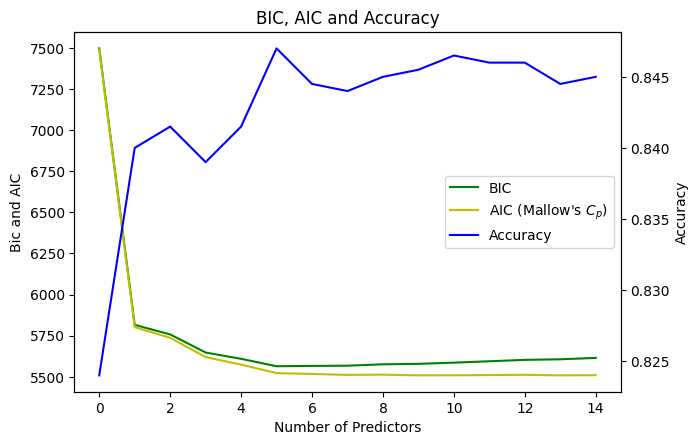

In [363]:
fig, ax1 = plt.subplots(figsize=(7, 5))

fig.tight_layout(pad=4.0)

ax2 = ax1.twinx()
BicPlot, = ax1.plot(bic, 'g-', label = "BIC")
AicPlot, = ax1.plot(aic, 'y-', label = "AIC (Mallow's $C_p$)")
AccuracyPlot, = ax2.plot(AccuracyTestData, 'b-', label="Accuracy")

plt.legend([BicPlot, AicPlot, AccuracyPlot], ['BIC', 'AIC (Mallow\'s $C_p$)', 'Accuracy'], loc = 'center right')

ax1.set_xlabel('Number of Predictors')
ax1.set_ylabel('Bic and AIC')
ax2.set_ylabel('Accuracy')
plt.title("BIC, AIC and Accuracy")
plt.savefig("BICAICandAccuracy")

In [364]:
print(bic.idxmin()) #Finds where minimum  and maximum values are
print(aic.idxmin())
print(AccuracyTestData.idxmax())

5
13
5


In [365]:
def Accuracy(row):
    indecies = [item for item in list(row["model"].params.index) if item != 'intercept']
    predictions = row["model"].predict(sm.add_constant(x_test[indecies]))
    return accuracy_score(y_test, predictions > 0.5)

AccuracyTestData = models_best.apply(Accuracy, axis=1)
AccuracyTestData
# i= 0
# asd = [item for item in list(models_best["model"][i].params.index) if item != 'intercept']
# # asd.remove('intercept')
# print(asd)
# models_best["model"][i].predict(sm.add_constant(x_test[asd]))
# accuracy_score(y_test, models_best["model"][i].predict(sm.add_constant(x_test[asd])) > 0.5)
# print()

# accuracy_score(y_test, )
# Accuracy = models_best.apply(lambda row: row["model"], axis=1) # get the parameters of the best model for each number of predictors


0     0.8240
1     0.8400
2     0.8415
3     0.8390
4     0.8415
5     0.8470
6     0.8445
7     0.8440
8     0.8450
9     0.8455
10    0.8465
11    0.8460
12    0.8460
13    0.8445
14    0.8450
dtype: float64